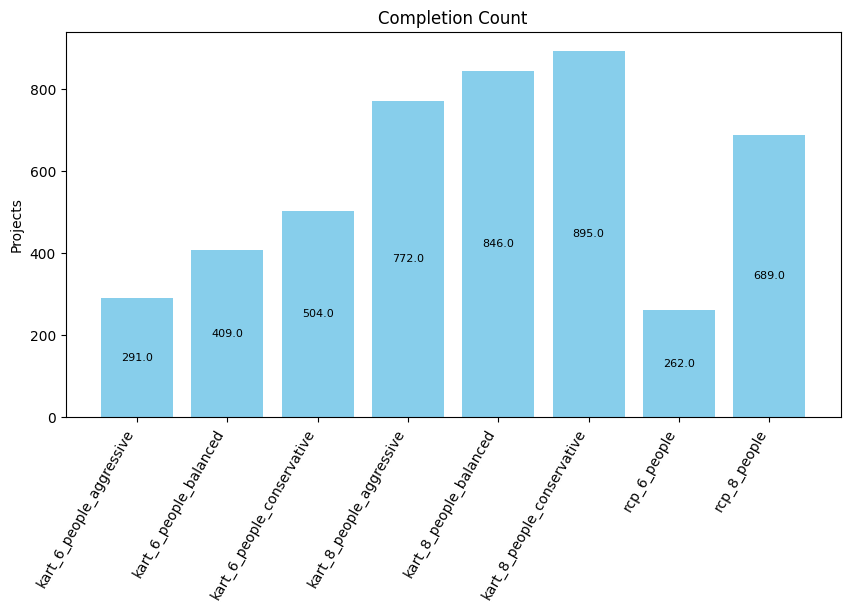

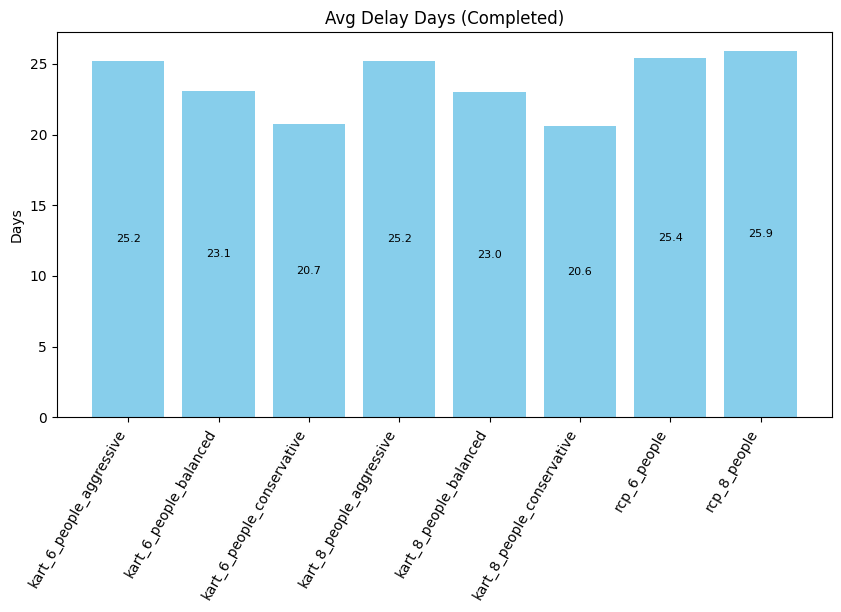

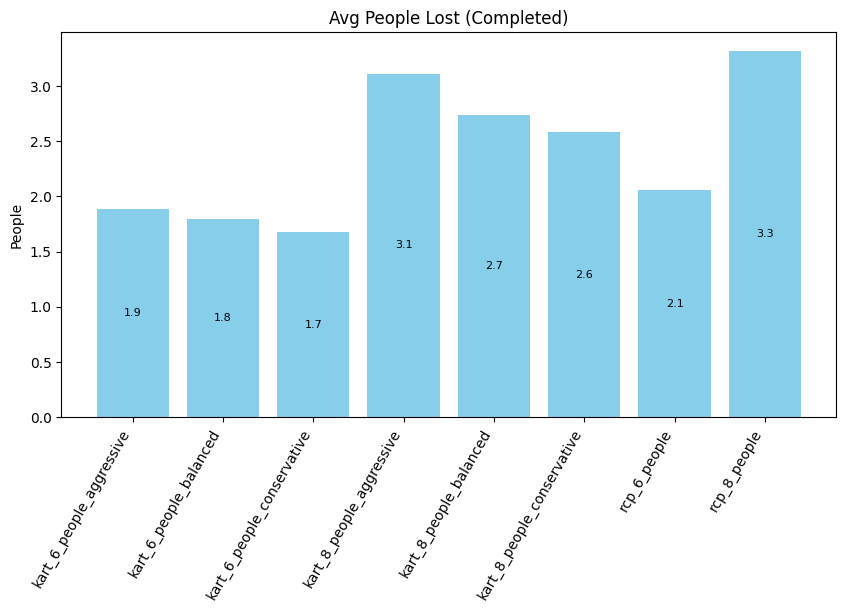

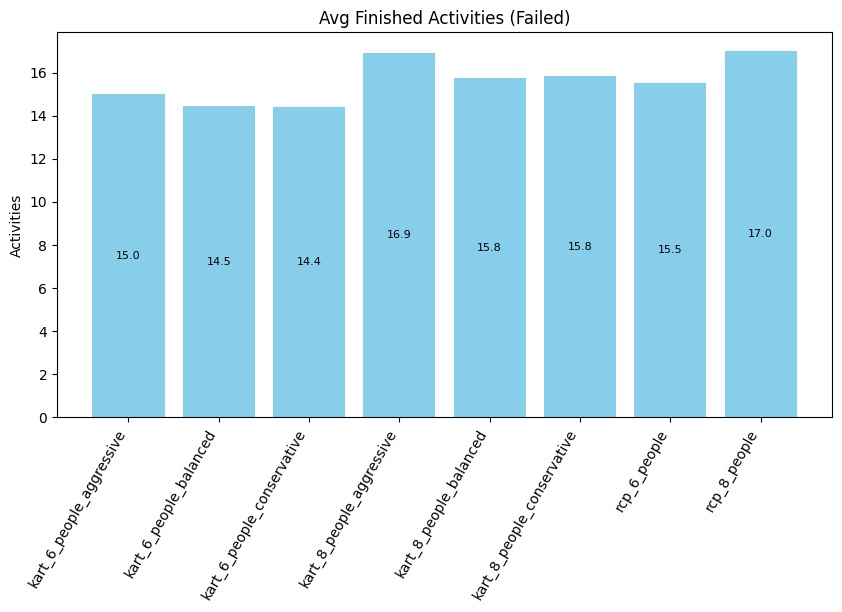

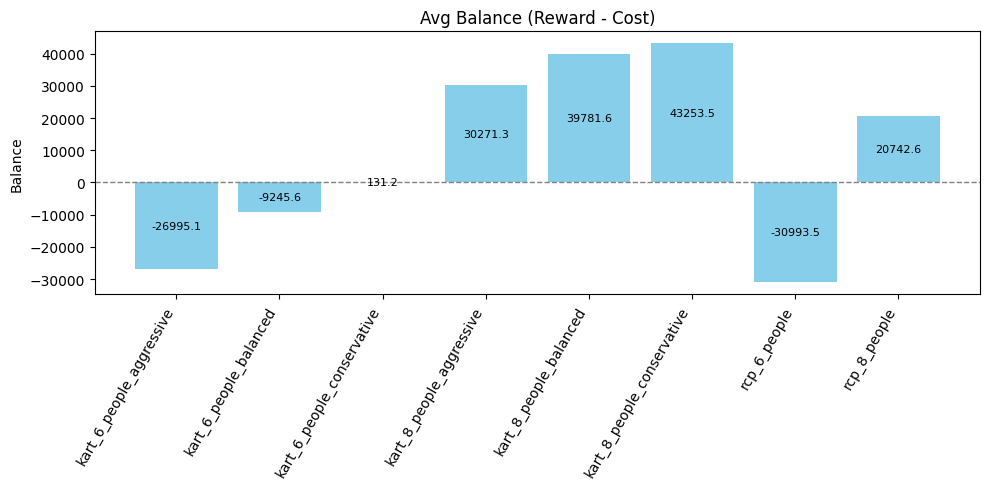

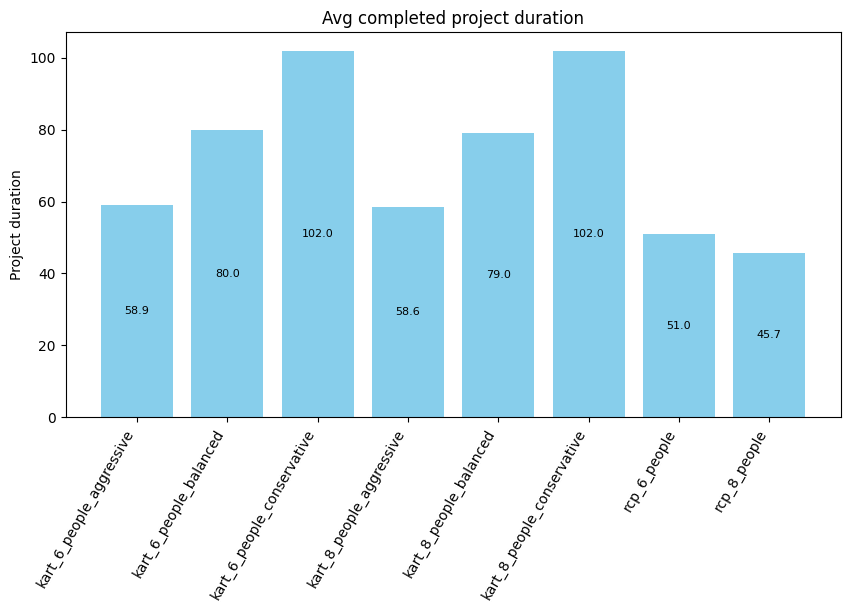

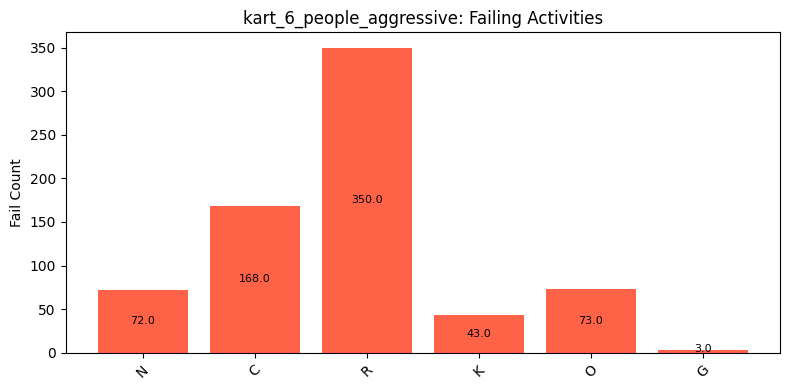

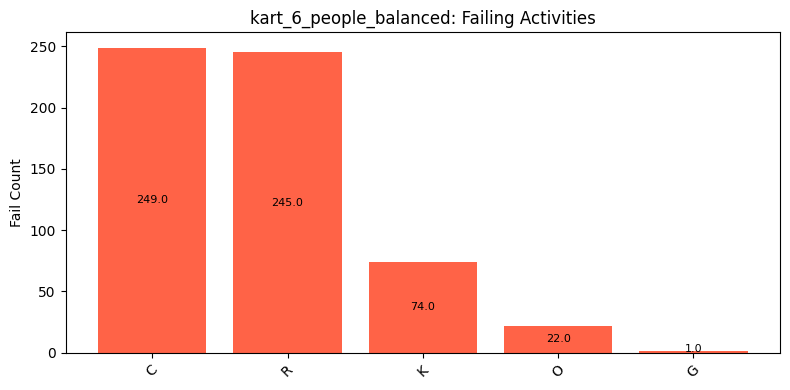

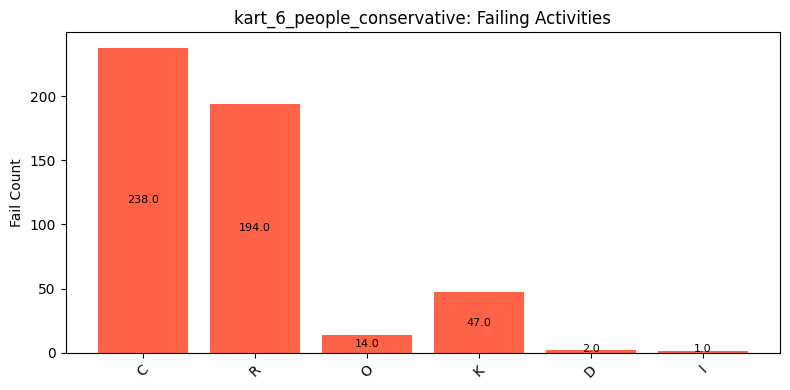

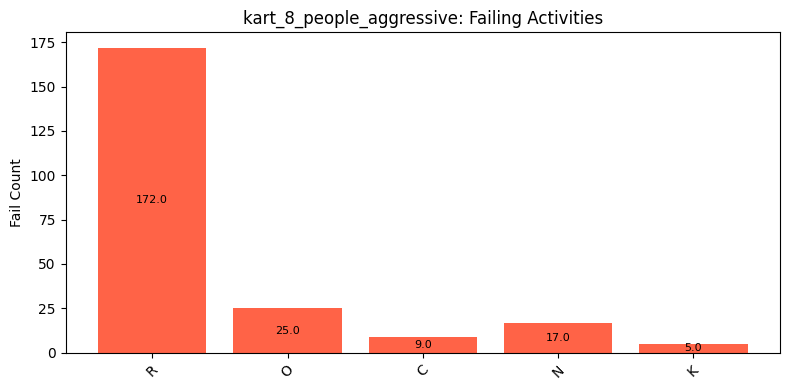

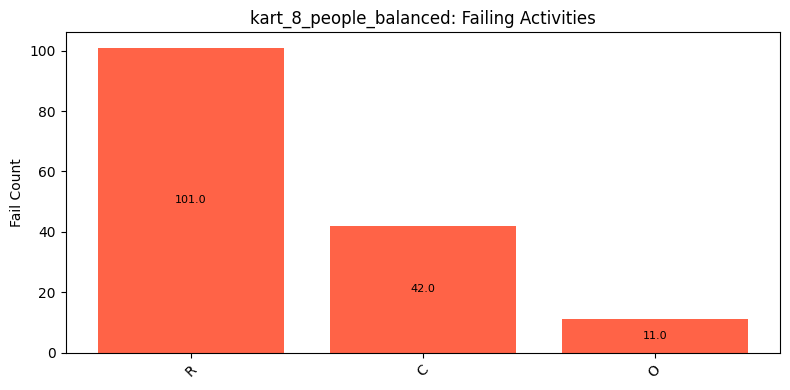

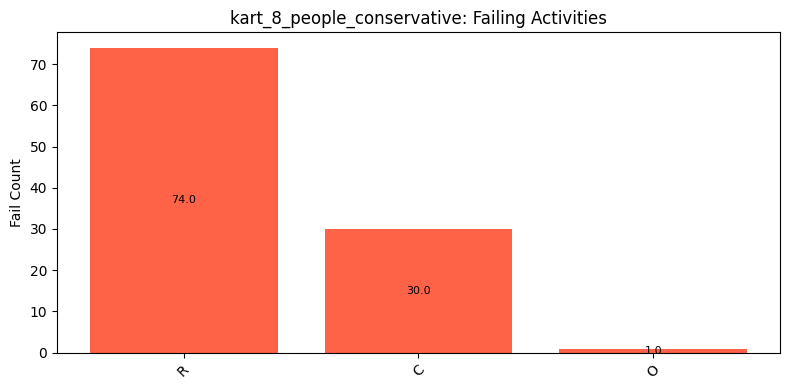

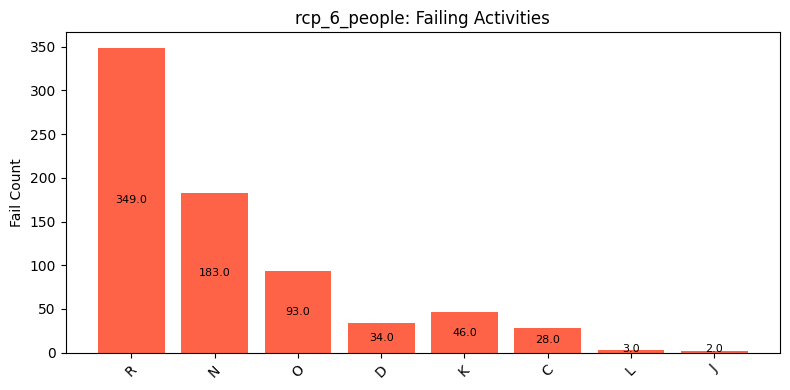

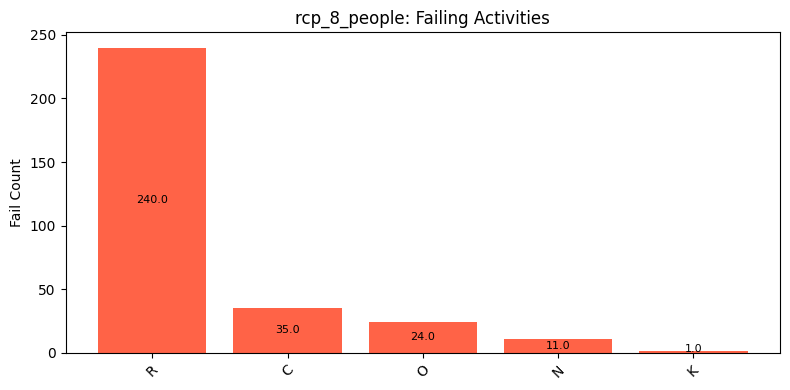


===== COMBINED GROUP SUMMARY =====

=== kart_6_people_aggressive ===
  - Completed Duration Avg: 58.92 | Stddev: 0.27
  - Failed Duration Avg:    43.74 | Stddev: 15.38
  - Avg Balance (All Runs): -26995.12 | Stddev: 59851.87

=== kart_6_people_balanced ===
  - Completed Duration Avg: 80.00 | Stddev: 0.00
  - Failed Duration Avg:    49.54 | Stddev: 17.26
  - Avg Balance (All Runs): -9245.65 | Stddev: 58966.80

=== kart_6_people_conservative ===
  - Completed Duration Avg: 102.00 | Stddev: 0.00
  - Failed Duration Avg:    64.69 | Stddev: 21.20
  - Avg Balance (All Runs): 131.18 | Stddev: 58872.22

=== kart_8_people_aggressive ===
  - Completed Duration Avg: 58.60 | Stddev: 0.49
  - Failed Duration Avg:    52.52 | Stddev: 10.51
  - Avg Balance (All Runs): 30271.30 | Stddev: 58406.46

=== kart_8_people_balanced ===
  - Completed Duration Avg: 79.00 | Stddev: 0.00
  - Failed Duration Avg:    58.36 | Stddev: 14.48
  - Avg Balance (All Runs): 39781.58 | Stddev: 46575.68

=== kart_8_people_co

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

BASE_FOLDER = r".\data\v2\results"
GROUPS = ["combined"]

REWARD = 150000  # fixed reward for successful completion

def load_and_process_group(group):
    path = os.path.join(BASE_FOLDER, group)
    group_stats = {}

    for file_name in os.listdir(path):
        if not file_name.endswith(".json"):
            continue

        with open(os.path.join(path, file_name), "r") as f:
            data = json.load(f)

        stats_entry = {
            "completion_rate": 0,
            "on_fail_finished_activities": [],
            "on_fail_total_duration": [],
            "fail_counts": {},
            "completed_total_cost": [],
            "completed_delay_days": [],
            "completed_people_lost": [],
            "completed_total_duration": [],
            "balances": [],
            "completed_total_project_duration": []
        }

        for run in data:
            cost = run.get("totalCost", 0)

            if run.get("projectFinished", True):
                stats_entry["completion_rate"] += 1
                reward = REWARD
                balance = reward - cost
                stats_entry["completed_total_cost"].append(cost)
                stats_entry["completed_delay_days"].append(run.get("totalDelayDays", 0))
                stats_entry["completed_people_lost"].append(len(run.get("peopleLost", [])))
                stats_entry["completed_total_duration"].append(run.get("totalProjectDuration", 0))
                stats_entry["completed_total_project_duration"].append(run.get("totalProjectDuration"))
            else:
                balance = -cost
                stats_entry["on_fail_finished_activities"].append(len(run.get("finishedActivities", [])))
                stats_entry["on_fail_total_duration"].append(run.get("totalProjectDuration", 0))
                failing_activity = run.get("failingActivity", {}).get("id", "unknown")
                stats_entry["fail_counts"][failing_activity] = stats_entry["fail_counts"].get(failing_activity, 0) + 1

            stats_entry["balances"].append(balance)

        group_stats[file_name] = stats_entry

    return group_stats

# Load both groups
all_stats = {group: load_and_process_group(group) for group in GROUPS}

# --- Plotting utilities ---
def bar_plot(values, labels, title, ylabel, highlight_zeros=False, round_ticks=False):
    fig_width = max(10, len(labels) * 1.2)
    fig, ax = plt.subplots(figsize=(fig_width, 5))
    bars = plt.bar(labels, values, color='skyblue')
    y_min, y_max = ax.get_ylim()
    offset = (y_max - y_min) * 0.01 
    min_height = y_min + offset
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height == 0.0:
            label = "No Completed" if highlight_zeros and values[i] == 0 else f"{values[i]:.1f}"
            color = 'red' if highlight_zeros and values[i] == 0 else 'black'
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                min_height,
                label,
                ha='center',
                va='bottom',
                fontsize=8,
                color=color,
                rotation=0
            )
        else:
            label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height / 2,
                label,
                ha='center',
                va='center',
                fontsize=8,
                color='black',
                rotation=0
            )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60, ha='right')

# --- Plotting utilities ---
def bar_plot_full(values, labels, title, ylabel, highlight_zeros=False, round_ticks=False):
    fig_width = max(10, len(labels) * 1.2)
    fig, ax = plt.subplots(figsize=(fig_width, 5))
    bars = plt.bar(labels, values, color='skyblue')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        label = f"{height:.1f}"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2,
            label,
            ha='center',
            va='center',
            fontsize=8,
            color='black',
            rotation=0
        )
    ax.axhline(0, color='gray', linewidth=1, linestyle='--')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60, ha='right')

    if round_ticks:
        y_max = max(values) * 1.1
        plt.yticks(np.round(np.linspace(0, y_max, num=6)))

    plt.tight_layout()
    plt.show()

def plot_failed_activities(file_name, stats):
    if stats["fail_counts"]:
        ids = list(stats["fail_counts"].keys())
        counts = list(stats["fail_counts"].values())
        fig, ax = plt.subplots(figsize=(8, 4))
        bars = plt.bar(ids, counts, color='tomato')
        y_min, y_max = ax.get_ylim()
        offset = (y_max - y_min) * 0.01   
        min_height = y_min + offset
        for i, bar in enumerate(bars):
            height = bar.get_height()
            label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height/2 if min_height < height else min_height,
                label,
                ha='center',
                va='center',
                fontsize=8,
                color='black',
                rotation=0
            )
        plt.title(f"{shorten_label(file_name)}: Failing Activities")
        plt.ylabel("Fail Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def shorten_label(name):
    base = os.path.splitext(name)[0]
    return base.replace("input_", "").replace("underground_", "").replace("_results", "")

def plot_group(group_name, group_data):
    labels = [shorten_label(name) for name in group_data.keys()]
    completion = [v["completion_rate"] for v in group_data.values()]
    avg_costs = [np.mean(v["completed_total_cost"]) if v["completed_total_cost"] else 0 for v in group_data.values()]
    avg_delays = [np.mean(v["completed_delay_days"]) if v["completed_delay_days"] else 0 for v in group_data.values()]
    avg_lost = [np.mean(v["completed_people_lost"]) if v["completed_people_lost"] else 0 for v in group_data.values()]
    avg_finished_on_fail = [np.mean(v["on_fail_finished_activities"]) if v["on_fail_finished_activities"] else 0 for v in group_data.values()]
    avg_balances = [np.mean(v["balances"]) if v["balances"] else 0 for v in group_data.values()]
    avg_project_duration = [np.mean(v["completed_total_project_duration"]) if v["completed_total_project_duration"] else 0 for v in group_data.values()]

    bar_plot(completion, labels, f"Completion Count", "Projects", highlight_zeros=True)
    bar_plot(avg_delays, labels, f"Avg Delay Days (Completed)", "Days", round_ticks=True)
    bar_plot(avg_lost, labels, f"Avg People Lost (Completed)", "People", round_ticks=True)
    bar_plot(avg_finished_on_fail, labels, f"Avg Finished Activities (Failed)", "Activities")
    bar_plot_full(avg_balances, labels, f"Avg Balance (Reward - Cost)", "Balance")
    bar_plot(avg_project_duration, labels, f"Avg completed project duration", "Project duration")


    for file_name, stats in group_data.items():
        plot_failed_activities(file_name, stats)

def print_group_stats(group_name, group_data):
    print(f"\n===== {group_name.upper()} GROUP SUMMARY =====")
    for file_name, stats in group_data.items():
        print(f"\n=== {shorten_label(file_name)} ===")
        if stats["completed_total_duration"]:
            print(f"  - Completed Duration Avg: {np.mean(stats['completed_total_duration']):.2f} | Stddev: {np.std(stats['completed_total_duration']):.2f}")
        if stats["on_fail_total_duration"]:
            print(f"  - Failed Duration Avg:    {np.mean(stats['on_fail_total_duration']):.2f} | Stddev: {np.std(stats['on_fail_total_duration']):.2f}")
        if stats["balances"]:
            print(f"  - Avg Balance (All Runs): {np.mean(stats['balances']):.2f} | Stddev: {np.std(stats['balances']):.2f}")

# Run all
for group_name, group_data in all_stats.items():
    plot_group(group_name, group_data)

for group_name, group_data in all_stats.items():
    print_group_stats(group_name, group_data)
